In [1]:
from pyspark import SparkConf, SparkContext
from operator import add
import re
import pandas as pd #用來呈現資料而已
import math

In [2]:
sc.stop()
conf = SparkConf().setMaster("local").setAppName("Term_Project")
sc = SparkContext(conf=conf)

In [3]:
data = []
for i in range (1,102):
    if i < 10:
        data.append(sc.textFile("00" + str(i) + ".txt").filter(lambda x: x != "")) #濾掉空行
    elif i >= 10 and i < 100:
        data.append(sc.textFile("0" + str(i) + ".txt").filter(lambda x: x != ""))
    else:
        data.append(sc.textFile(str(i) + ".txt").filter(lambda x: x != ""))

## 把多餘的symbol移除，再做k=3的shingling

In [4]:
k = 3
# remove unimportant symbols
def shingling(line):
    line = line.replace(',"','')
    line = line.replace('."','')
    line = line.replace('!"','')
    line = line.replace(',','')
    line = line.replace(' & ',' ')
    line = line.replace('&','')
    line = line.replace('...','')
    line = line.replace('(','')
    line = line.replace(')','')
    line = line.replace(' " ',' ')
    line = line.replace('. ',' ')
    line = line.replace(' .',' ')
    line = line.replace(':','')
    line = line.replace(' "',' ')
    line = line.replace("''",'')
    line = line.replace(" '",' ')
    line = line.replace("' ",' ')
    line = line.replace('"','')
    line = re.sub(r"'$",'',line)
    line = re.sub(r"^'",'',line)
    line = line.replace(' - ',' ')
    line = line.replace('- ',' ')
    line = line.rstrip('.')
    line = line.strip()
    tokens = line.split(' ')
    shingle = [(' '.join(tokens[i:i+k]),1)
                     for i in range(len(tokens) - k + 1)]
    return shingle

## 計算出全部shingling 

In [5]:
shi = sc.parallelize([])
t = []
for i in range (len(data)):
    t.append(data[i].map(shingling).reduce(add))
    shi = shi.union(sc.parallelize(t[i]).map(lambda x:(x[0],1)))

## 將全部的shingling sortByKey 再給予index以確定每個shingling的位置

In [6]:
#全部的shingles (index start from 0)
sh = sc.broadcast(shi.reduceByKey(add).sortByKey().map(lambda x:x[0]).zipWithIndex().collect())

In [7]:
pd.DataFrame(sh.value)

,0,1
0,$25m £13m in,0
1,$30000 so she,1
2,0.02 seconds behind,2
3,0.04secs slower in,3
4,0.19secs to secure,4
...,...,...
25808,zinc supplement Conte,25808
25809,£100000 for the,25809
25810,£13m in the,25810
25811,£25000 after opting,25811


# hash function setting (a,b,p,N)
h(x) = ((ax+b) mod p) mod N
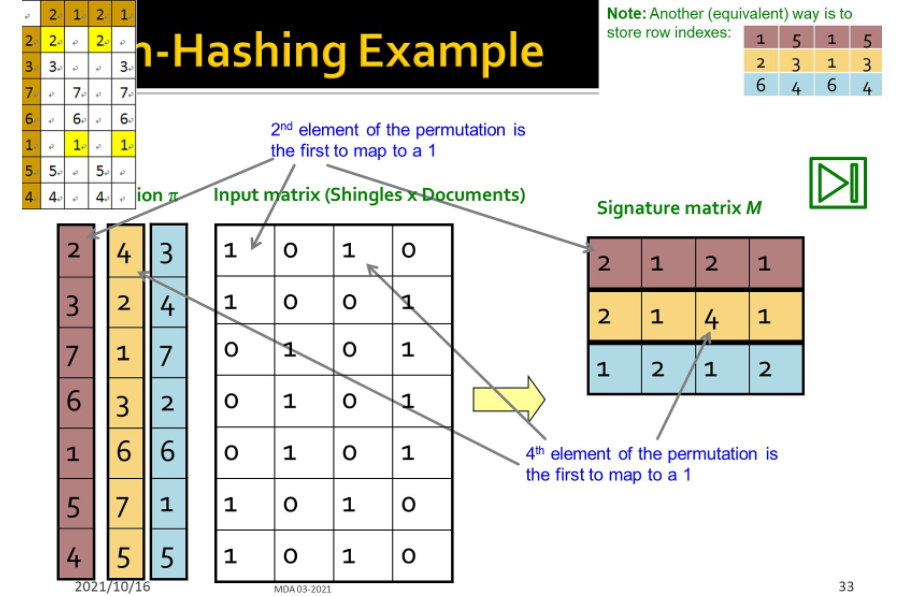

In [8]:
import random
a = []
b = []
for i in range(10):
    a.append(random.randint(1,100))
    b.append(random.randint(1,100))
p = 25819 #25819是大於25813最小的質數
N = 25813
x = list(range(1,25813+1)) #有25813個row

In [9]:
permutation = []
for i in a: #a
    for j in b: #b
        row_t = []
        for k in x: #x
            row_t.append((i*k+j)%p%N)
        permutation.append(row_t)

### num of hash function

In [10]:
len(permutation)

100

## 用每個file有個shingling去sh搜到相對應的位置，再根據這個位置去permutation的地方找到相對應的hash值
每個hash function都會產生一個下圖
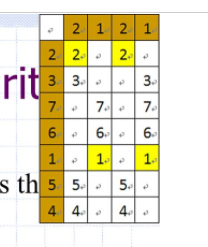

In [11]:
def minhash(line):
    s = line[0]
    index = -1
    index_s = []
    for i in range(len(sh.value)):
        if sh.value[i][0] == s:
            index = sh.value[i][1]
            break
    for j in range(len(permutation)): #every hash function
        index_s.append(permutation[j][index])
    return index_s

In [12]:
chart = []
for i in range(len(data)):
    chart.append(sc.broadcast(sc.parallelize(t[i]).map(minhash).collect()))

In [13]:
pd.DataFrame(chart[0].value) #某一hash function對每個file的shingling做的hash值(如上圖省略空白部分)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,7651,7644,7700,7635,7676,7625,7702,7661,7638,7681,...,4876,4869,4925,4860,4901,4850,4927,4886,4863,4906
1,620,613,669,604,645,594,671,630,607,650,...,10889,10882,10938,10873,10914,10863,10940,10899,10876,10919
2,605,598,654,589,630,579,656,615,592,635,...,6565,6558,6614,6549,6590,6539,6616,6575,6552,6595
3,21518,21511,21567,21502,21543,21492,21569,21528,21505,21548,...,14095,14088,14144,14079,14120,14069,14146,14105,14082,14125
4,800,793,849,784,825,774,851,810,787,830,...,11139,11132,11188,11123,11164,11113,11190,11149,11126,11169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,8429,8422,8478,8413,8454,8403,8480,8439,8416,8459,...,219,212,268,203,244,193,270,229,206,249
198,13475,13468,13524,13459,13500,13449,13526,13485,13462,13505,...,24440,24433,24489,24424,24465,24414,24491,24450,24427,24470
199,16073,16066,16122,16057,16098,16047,16124,16083,16060,16103,...,19442,19435,19491,19426,19467,19416,19493,19452,19429,19472
200,2378,2371,2427,2362,2403,2352,2429,2388,2365,2408,...,21937,21930,21986,21921,21962,21911,21988,21947,21924,21967


## 得知每個shingling的hash值後，取每個hash function中最小的hash值，為此file中的min hash value
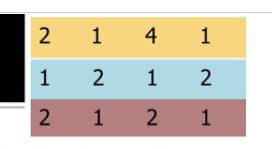

In [14]:
def pickmin(line):
    chart_i = []
    for i in range(len(chart)): #101個file
        index_s = []
        for j in range(100): #100個hash function
            min_i = math.inf
            for k in range(len(chart[i].value)): #一個file裡有幾個為1個shingling
                if chart[i].value[k][j] < min_i:
                    min_i = chart[i].value[k][j]
            index_s.append(min_i) #一個file在某個hash function的min index
        chart_i.append(index_s) #會記錄多個file之某個hash function的min index
    return chart_i

In [15]:
sig = []
for i in range(len(chart)):
    sig.append(sc.broadcast(sc.parallelize([1]).map(pickmin).collect()[0][i]))

In [16]:
pd.DataFrame(sig[0].value) #某一個file 100 hash function出來的min

,0
0,76
1,69
2,125
3,60
4,101
...,...
95,193
96,48
97,7
98,206


In [17]:
b = 50 #band
r = 2 #integers/band
s = 0.8 #threshold

## 從min hash value計算每兩file是否為candidate pair，是candidate pair就把兩file的index記錄下來
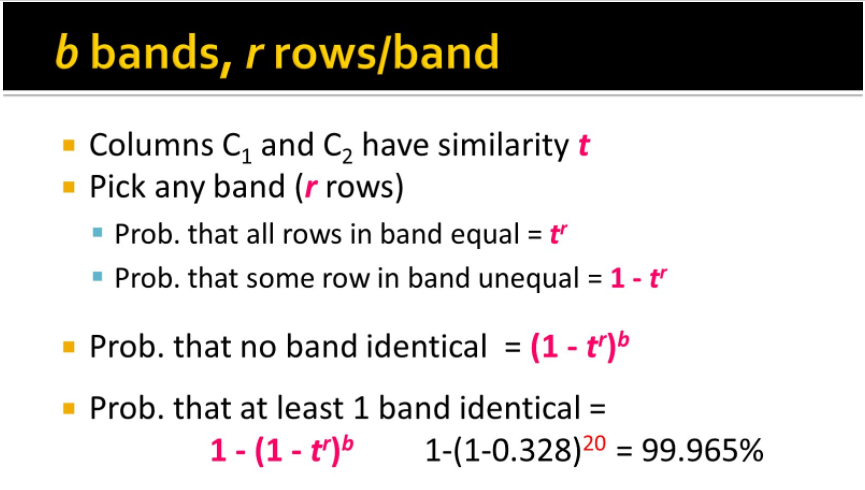

In [18]:
# candidate pair
def LSH(line):
    sim_list = []
    for i in range(len(sig)): #file num
        for j in range(i+1,len(sig)):
            sim = 0
            for k in range(len(sig[i].value)):
                if sig[i].value[k] == sig[j].value[k]: #2個file signature相似 (共100個hash function)
                    sim += 1
            num = 1-((1-((sim/100)**r))**b) #至少有一個band hash到同一個bucket
            if num > s: # "num"% pairs are truly similar documents(sim%)
                sim_list.append((i,j))
    return sim_list

## 根據candidate pair去計算(下圖input matrix的)jaccard similarity
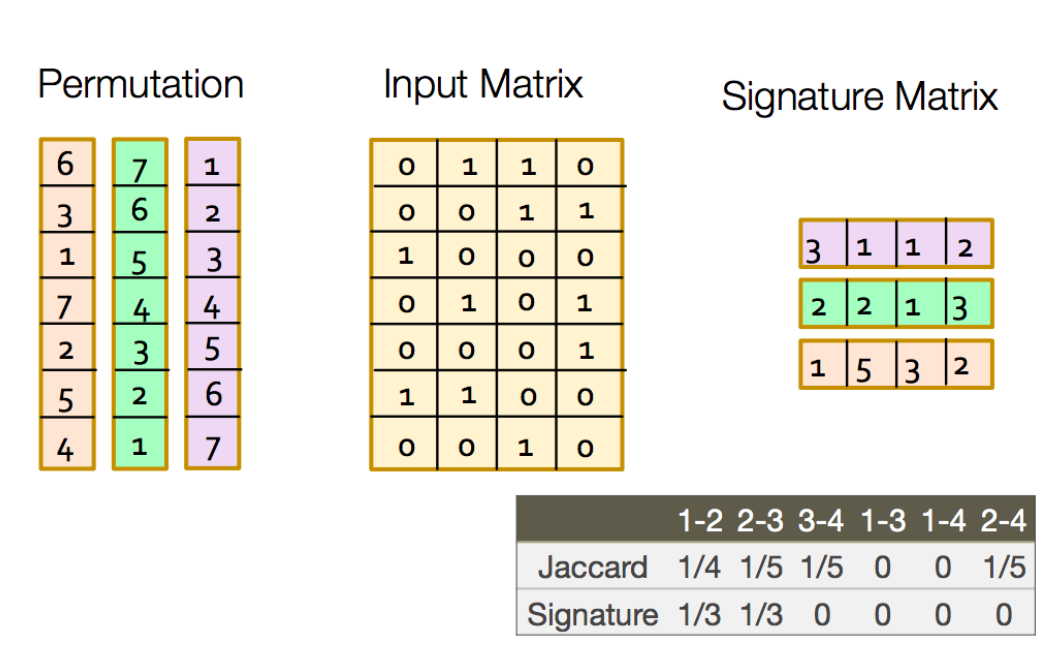

In [19]:
def jaccard(line):
    i = line[0]
    j = line[1]
    shi_i = set(t[i])
    shi_j = set(t[j])
    common = shi_i.union(shi_j)
    jac = (len(shi_i)+len(shi_j)-len(common))/len(common)
    str1 = ""
    str2 = ""
    i += 1
    j += 1
    if i < 10:
        str1 = "00" + str(i)
    elif i < 100:
        str1 = "0" + str(i)
    else:
        str1 = str(i)
    if j < 10:
        str2 = "00" + str(j)
    elif j < 100:
        str2 = "0" + str(j)
    else:
        str2 = str(j)
    return ((str1,str2),jac)

## 然後再根據jaccard similarity由大到小排序

In [20]:
output = sc.parallelize(sc.parallelize([1]).map(LSH).collect()[0]).map(jaccard).sortBy(lambda x:x[1],ascending = False).collect()

In [21]:
f = open('Outputfile.txt','w')
for i in range (10):
    f.write("(" + str(output[i][0][0]) + ", " + str(output[i][0][1]) + "): " + str(round(output[i][1]*100,2)) + "%\n")
f.close()